# Backtesting a Strategy

We're all set to test a basic trading strategy using **PyBroker**! To get started, we'll import the necessary classes listed below:

In [1]:
import pybroker
from pybroker import Strategy, StrategyConfig, YFinance

pybroker.enable_data_source_cache('my_strategy')

For our backtest, we'll be using [Yahoo Finance](https://finance.yahoo.com) as our [DataSource](https://www.pybroker.com/en/latest/reference/pybroker.data.html#pybroker.data.DataSource). We'll also be using data source caching to ensure that we only download the necessary data once when we run our backtests.

The next step is to set up a new instance of the [Strategy](https://www.pybroker.com/en/latest/reference/pybroker.strategy.html#pybroker.strategy.Strategy) class which will be used to perform a backtest on our trading strategy. Here's how you can do it:

First, you can create a [StrategyConfig](https://www.pybroker.com/en/latest/reference/pybroker.config.html#pybroker.config.StrategyConfig) object to configure the ```Strategy```. In this case, we're setting the initial cash to ```500,000```:

In [2]:
config = StrategyConfig(initial_cash=500_000)

Then, you can create a new instance of the ```Strategy``` class by passing in the following arguments:

- A data source: In this case, we're using Yahoo Finance as the data source.
- A start date: This is the starting date for the backtest.
- An end date: This is the end date for the backtest.
- The configuration object created earlier.

In [3]:
strategy = Strategy(YFinance(), '3/1/2017', '3/1/2022', config)

The ```Strategy``` instance is now ready to download data from Yahoo Finance for the period between March 1, 2017, and March 1, 2022, before running the backtest using the specified configuration options. If you need to modify other configuration options, you can refer to the [StrategyConfig reference documentation](https://www.pybroker.com/en/latest/reference/pybroker.config.html#pybroker.config.StrategyConfig).

## Defining Strategy Rules

In this section, you will learn how to implement a basic trading strategy in **PyBroker** with the following rules:

1. Buy shares in a stock if the last close price is less than the low of the previous bar and there is no open long position in that stock.
2. Set the limit price of the buy order to 0.01 less than the last close price.
3. Hold the position for 3 days before liquidating it at market price.
4. Trade the rules on AAPL and MSFT, allocating up to 25% of the portfolio to each.

To accomplish this, you will define a ```buy_low``` function that **PyBroker** will call separately for AAPL and MSFT on every bar of data. Each bar corresponds to a single day of data:

In [4]:
def buy_low(ctx):
    # If shares were already purchased and are currently being held, then return.
    if ctx.long_pos():
        return
    # If the latest close price is less than the previous day's low price,
    # then place a buy order.
    if ctx.bars >= 2 and ctx.close[-1] < ctx.low[-2]:
        # Buy a number of shares that is equal to 25% the portfolio.
        ctx.buy_shares = ctx.calc_target_shares(0.25)
        # Set the limit price of the order.
        ctx.buy_limit_price = ctx.close[-1] - 0.01
        # Hold the position for 3 bars before liquidating (in this case, 3 days).
        ctx.hold_bars = 3

That is a lot to unpack! The ```buy_low``` function will receive an [ExecContext](https://www.pybroker.com/en/latest/reference/pybroker.context.html#pybroker.context.ExecContext) (```ctx```) containing data for the current ticker symbol (AAPL or MSFT). The ```ExecContext``` will contain all of the close prices up until the most recent bar of the current ticker symbol. The latest close price is retrieved with ```ctx.close[-1]```.

The ```buy_low``` function will use the ```ExecContext``` to place a buy order. The number of shares to purchase is set using [ctx.buy_shares](https://www.pybroker.com/en/latest/reference/pybroker.context.html#pybroker.context.ExecContext.buy_shares), which is calculated with [ctx.calc_target_shares](https://www.pybroker.com/en/latest/reference/pybroker.context.html#pybroker.context.ExecContext.calc_target_shares). In this case, the number of shares to buy will be equal to 25% of the portfolio. 

The limit price of the order is set with [buy_limit_price](https://www.pybroker.com/en/latest/reference/pybroker.context.html#pybroker.context.ExecContext.buy_limit_price). If the criteria are met, the buy order will be filled on the next bar. The time at which the order is filled can be configured with [StrategyConfig.buy_delay](https://www.pybroker.com/en/latest/reference/pybroker.config.html#pybroker.config.StrategyConfig.buy_delay), and its fill price can be set with [ExecContext.buy_fill_price](https://www.pybroker.com/en/latest/reference/pybroker.context.html#pybroker.context.ExecContext.buy_fill_price). By default, buy orders are filled on the next bar (```buy_delay=1```) and at a [fill price equal to the midpoint between that bar's low and high price](https://www.pybroker.com/en/latest/reference/pybroker.common.html#pybroker.common.PriceType.MIDDLE).

Finally, [ctx.hold_bars](https://www.pybroker.com/en/latest/reference/pybroker.context.html#pybroker.context.ExecContext.hold_bars) specifies how many bars to hold the position for before liquidating it. When liquidated, the shares are sold at market price equal to [ExecContext.sell_fill_price](https://www.pybroker.com/en/latest/reference/pybroker.context.html#pybroker.context.ExecContext.sell_fill_price), which is configurable and defaults to the midpoint between the bar's low and high price.

To add the ```buy_low``` rules to the ```Strategy``` for AAPL and MSFT, you will use [add_execution](https://www.pybroker.com/en/latest/reference/pybroker.strategy.html#pybroker.strategy.Strategy.add_execution):

In [5]:
strategy.add_execution(buy_low, ['AAPL', 'MSFT'])

## Adding a Second Execution

You can use different sets of trading rules for different tickers within the same ```Strategy``` instance. In other words, you are not restricted to using only one set of trading rules for a single group of tickers. 

To demonstrate this, a new set of rules for a short strategy is provided in a function called ```short_high```, which is similar to the previous set of rules:

In [6]:
def short_high(ctx):
    # If shares were already shorted then return.
    if ctx.short_pos():
        return
    # If the latest close price is more than the previous day's high price,
    # then place a sell order.
    if ctx.bars >= 2 and ctx.close[-1] > ctx.high[-2]:
        # Short 100 shares.
        ctx.sell_shares = 100
        # Cover the shares after 2 bars (in this case, 2 days).
        ctx.hold_bars = 2

The rules in ```short_high``` will be traded on ```TSLA```:

In [7]:
strategy.add_execution(short_high, ['TSLA'])

(Note, you can also retrieve bar data for another symbol by calling [ExecContext#foreign](https://www.pybroker.com/en/latest/reference/pybroker.context.html#pybroker.context.ExecContext.foreign))

## Running a Backtest

To run a backtest, call the [backtest](https://www.pybroker.com/en/latest/reference/pybroker.strategy.html#pybroker.strategy.Strategy.backtest) method on the ```Strategy``` instance. Here is an example:

In [8]:
result = strategy.backtest()

Backtesting: 2017-03-01 00:00:00 to 2022-03-01 00:00:00

Loading bar data...


[*********************100%***********************]  3 of 3 completed

Loaded bar data: 0:00:01 

Test split: 2017-03-01 00:00:00 to 2022-02-28 00:00:00



100% (1259 of 1259) |####################| Elapsed Time: 0:00:00 Time:  0:00:000:00



Finished backtest: 0:00:03


That was fast! The ```backtest``` method will return an instance of [TestResult](https://www.pybroker.com/en/latest/reference/pybroker.strategy.html#pybroker.strategy.TestResult). You can access various information and metrics about the backtest through this instance. For example, to see the daily balances of the portfolio, you can plot the market value using [Matplotlib](https://matplotlib.org/):

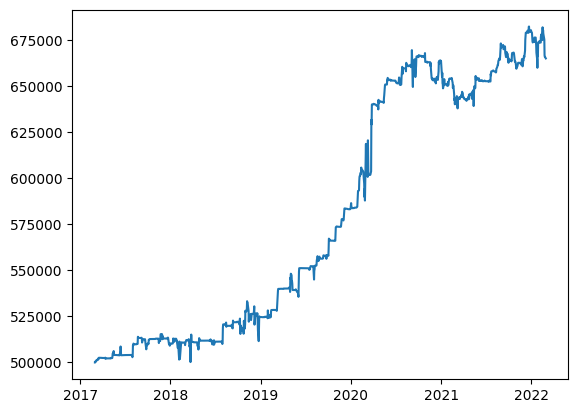

In [9]:
import matplotlib.pyplot as plt

chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])

You can also access the daily balance of each position that was held, the trades that were made for every entry and exit, and all of the orders that were placed:

In [10]:
result.positions

long_shares  short_shares   close     equity  market_value  \
symbol date                                                                     
MSFT   2017-03-03         1952             0   64.25  125416.00     125416.00   
       2017-03-06         1952             0   64.27  125455.03     125455.03   
       2017-03-07         1952             0   64.40  125708.80     125708.80   
       2017-03-14         1937             0   64.41  124762.18     124762.18   
TSLA   2017-03-15            0           100   17.05       0.00       1718.00   
...                        ...           ...     ...        ...           ...   
MSFT   2022-02-22          583             0  287.72  167740.76     167740.76   
AAPL   2022-02-22         1005             0  164.32  165141.61     165141.61   
MSFT   2022-02-23          583             0  280.27  163397.40     163397.40   
AAPL   2022-02-23         1005             0  160.07  160870.36     160870.36   
TSLA   2022-02-28            0           100  290.14       0.00      28193.00   

                     margin  unrealized_pnl  
symbol date                                  
MSFT   2017-03-03      0.00          585.60  
       2017-03-06      0.00          624.63  
       2017-03-07      0.00          878.40  
       2017-03-14      0.00          116.23  
TSLA   2017-03-15   1704.87           13.13  
...                     ...             ...  
MSFT   2022-02-22      0.00        -1375.88  
AAPL   2022-02-22      0.00        -4060.19  
MSFT   2022-02-23      0.00        -5719.24  
AAPL   2022-02-23      0.00        -8331.44  
TSLA   2022-02-28  29014.33         -821.33  

[938 rows x 7 columns]

In [11]:
result.trades

,type,symbol,entry_date,exit_date,entry,exit,shares,pnl,return_pct,agg_pnl,bars,pnl_per_bar,stop,mae,mfe
id,,,,,,,,,,,,,,,
1,long,MSFT,2017-03-03,2017-03-08,63.95,64.67,1952,1405.44,1.13,1405.44,3,468.48,bar,-0.33,0.83
2,long,MSFT,2017-03-14,2017-03-17,64.35,64.96,1937,1181.57,0.95,2587.01,3,393.86,bar,-0.20,0.61
3,short,TSLA,2017-03-15,2017-03-17,17.18,17.55,100,-37.00,-2.11,2550.01,2,-18.50,bar,-0.54,0.23
4,short,TSLA,2017-03-27,2017-03-29,17.68,18.50,100,-82.00,-4.43,2468.01,2,-41.00,bar,-1.03,0.36
5,short,TSLA,2017-04-04,2017-04-06,19.98,19.87,100,11.00,0.55,2479.01,2,5.50,bar,-0.35,0.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,long,AAPL,2022-02-11,2022-02-16,170.56,171.69,984,1111.92,0.66,180139.06,3,370.64,bar,-4.00,2.52
385,long,MSFT,2022-02-11,2022-02-16,299.26,297.27,560,-1114.40,-0.66,179024.66,3,-371.47,bar,-7.91,5.03
386,short,TSLA,2022-02-16,2022-02-18,304.61,287.41,100,1720.00,5.98,180744.66,2,860.00,bar,-4.20,17.20


In [12]:
result.orders

,type,symbol,date,shares,limit_price,fill_price,fees
id,,,,,,,
1,buy,MSFT,2017-03-03,1952,64.00,63.95,0.0
2,sell,MSFT,2017-03-08,1952,NaN,64.67,0.0
3,buy,MSFT,2017-03-14,1937,64.70,64.35,0.0
4,sell,TSLA,2017-03-15,100,NaN,17.18,0.0
5,sell,MSFT,2017-03-17,1937,NaN,64.96,0.0
...,...,...,...,...,...,...,...
773,buy,AAPL,2022-02-18,1005,168.87,168.36,0.0
774,buy,MSFT,2022-02-18,583,290.72,290.08,0.0
775,sell,AAPL,2022-02-24,1005,NaN,157.43,0.0


Additionally, ```result.metrics_df``` contains a DataFrame of metrics calculated using the returns of the backtest. [You can read about what these metrics mean on the reference documentation](https://www.pybroker.com/en/latest/reference/pybroker.eval.html#pybroker.eval.EvalMetrics).

In [13]:
result.metrics_df

,name,value
0,trade_count,388.000000
1,initial_market_value,500000.000000
2,end_market_value,665009.260000
3,total_pnl,165830.590000
4,unrealized_pnl,-821.330000
5,total_return_pct,33.166118
6,total_profit,402053.210000
7,total_loss,-236222.620000
8,total_fees,0.000000
9,max_drawdown,-31619.460000


## Filtering Backtest Data

You can filter the data used for the backtest to only include specific bars. For example, you can limit the strategy to trade only on Mondays by filtering the data to only contain bars for Mondays:

In [14]:
result = strategy.backtest(days='mon')
result.orders

Backtesting: 2017-03-01 00:00:00 to 2022-03-01 00:00:00

Loaded cached bar data.

Test split: 2017-03-06 00:00:00 to 2022-02-28 00:00:00


100% (238 of 238) |######################| Elapsed Time: 0:00:00 Time:  0:00:000:00



Finished backtest: 0:00:00


,type,symbol,date,shares,limit_price,fill_price,fees
id,,,,,,,
1,sell,TSLA,2017-03-27,100,NaN,17.68,0.0
2,buy,TSLA,2017-04-10,100,NaN,20.75,0.0
3,sell,TSLA,2017-04-17,100,NaN,20.09,0.0
4,buy,TSLA,2017-05-01,100,NaN,21.40,0.0
5,sell,TSLA,2017-05-08,100,NaN,20.65,0.0
...,...,...,...,...,...,...,...
178,sell,TSLA,2022-02-07,100,NaN,308.41,0.0
179,sell,AAPL,2022-02-14,777,NaN,168.07,0.0
180,buy,MSFT,2022-02-14,457,300.94,294.06,0.0


The data doesn't need to be downloaded again from Yahoo Finance because caching is enabled and the cached data only needs to be filtered.

You can also filter the data by time range, such as 9:30-10:30 AM, using the [between_time](https://www.pybroker.com/en/latest/reference/pybroker.strategy.html#pybroker.strategy.Strategy.backtest) argument.

Although the metrics earlier indicate that we have a profitable strategy, we may be misled by randomness. [In the next notebook, we'll discuss how to use bootstrapping to further evaluate our trading strategies](https://www.pybroker.com/en/latest/notebooks/3.%20Evaluating%20with%20Bootstrap%20Metrics.html).